So here im training ZERO-DCE model to get the pretrained weights and use it for my project

In [ ]:
# !gdown 1viaxl1sYNSp6wQLDRk2Z1NqFYdKgQWqz

Downloading...
From (original): https://drive.google.com/uc?id=1viaxl1sYNSp6wQLDRk2Z1NqFYdKgQWqz
From (redirected): https://drive.google.com/uc?id=1viaxl1sYNSp6wQLDRk2Z1NqFYdKgQWqz&confirm=t&uuid=2163c9b6-b67f-4b53-a999-7faccb54856a
To: /content/model_epochs_17_batch_3000_03-01-2022_08h22.pth
100% 74.0M/74.0M [00:03<00:00, 18.7MB/s]


In [ ]:
!pip install -q torchmetrics lpips torch-fidelity tqdm timm pyspng

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 9.7 MB/s eta 0:00:00


In [ ]:
!gdown 1GVgwCWCvwTD8rwRUbL_NdNO9w5FsNEDt # new train imgs

Downloading...
From: https://drive.google.com/uc?id=1GVgwCWCvwTD8rwRUbL_NdNO9w5FsNEDt
To: /content/train_images_for_lama_mat.zip
100% 21.8M/21.8M [00:00<00:00, 23.1MB/s]


In [ ]:
# # !git clone https://github.com/Li-Chongyi/Zero-DCE.git
# !gdown 1u_nme6-H4SD7Pl1sJ0u9AWUjIQGRgFB8  # for mask download
# ! gdown 1cBcNZvKiA19RS78yzUyg8KuFwbgictnO # for lama download
# !gdown 1-1y31xO5KVNOYFgxNX2NIMGEEC6syYwS #  for mat download

Downloading...
From (original): https://drive.google.com/uc?id=1u_nme6-H4SD7Pl1sJ0u9AWUjIQGRgFB8
From (redirected): https://drive.google.com/uc?id=1u_nme6-H4SD7Pl1sJ0u9AWUjIQGRgFB8&confirm=t&uuid=1658349f-c313-4ecc-9a59-aced418f0677
To: /content/only_masked.zip
100% 63.7M/63.7M [00:00<00:00, 111MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1cBcNZvKiA19RS78yzUyg8KuFwbgictnO
From (redirected): https://drive.google.com/uc?id=1cBcNZvKiA19RS78yzUyg8KuFwbgictnO&confirm=t&uuid=4c031126-eadd-443a-9580-0dc4a4ffcfdd
To: /content/lama.zip
100% 340M/340M [00:04<00:00, 82.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-1y31xO5KVNOYFgxNX2NIMGEEC6syYwS
From (redirected): https://drive.google.com/uc?id=1-1y31xO5KVNOYFgxNX2NIMGEEC6syYwS&confirm=t&uuid=260b8e32-1d9e-4a75-877d-1b52a292f45a
To: /content/mat.zip
100% 281M/281M [00:04<00:00, 58.9MB/s]


In [ ]:
# make the dataset but before try how to make the mask for the images
import numpy as np
from numpy.random import uniform
from numpy import *
from math import *

marg = 10
p_irr = 0.5 # probability of a polygonal chain mask
min_n_irr = 3
max_n_irr = 5
max_l_irr = 200
max_w_irr = 150

min_n_box = 3
max_n_box = 5
min_s_box = 50
max_s_box = 150

def gen_large_mask(img_h, img_w, n):

  """ img_h: int, an image height
  img_w: int, an image width
  marg: int, a margin for a box starting coordinate
  p_irr: float, 0 <= p_irr <= 1, a probability of a polygonal chain mask

  min_n_irr: int, min number of segments
  max_n_irr: int, max number of segments
  max_l_irr: max length of a segment in polygonal chain
  max_w_irr: max width of a segment in polygonal chain

  min_n_box: int, min bound for the number of box primitives
  max_n_box: int, max bound for the number of box primitives
  min_s_box: int, min length of a box side
  max_s_box: int, max length of a box side"""

  mask = ones((img_h, img_w))

  if np.random.uniform(0,1) < p_irr: # generate polygonal chain
    n = uniform(min_n_irr, max_n_irr) # sample number of segments

  for _ in range(int(n)):
    y = uniform(0, img_h) # sample a starting point
    x = uniform(0, img_w)

    a = uniform(0, 360) # sample angle
    l = uniform(10, max_l_irr) # sample segment length
    w = uniform(5, max_w_irr) # sample a segment width

    # draw segment starting from (x,y) to (x_,y_) using brush of width w
    x_ = x + l * sin(a)
    y_ = y + l * cos(a)

    gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
    x, y = x_, y_
  else: # generate Box masks
    n = uniform(min_n_box, max_n_box) # sample number of rectangles

    for _ in range(int(n)):
      h = uniform(min_s_box, max_s_box) # sample box shape
      w = uniform(min_s_box, max_s_box)

      x_0 = uniform(marg, img_w - marg + w) # sample upper-left coordinates of box
      y_0 = uniform(marg, img_h - marg - h)
      gen_box_mask(mask, size=(img_w, img_h), masked=(x_0, y_0, w, h))
  return mask

def gen_box_mask(mask, size, masked):
  x_0, y_0, w, h = masked
  x_0, y_0, w, h  = int(x_0), int(y_0), int(w), int(h)
  mask[x_0 : x_0 + w, y_0 : y_0 + h] = 0
  return mask

#gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
def gen_segment_mask(mask, start, end, brush_width):
  x, y = start
  x_, y_ = end

  dx = x_ - x
  dy = y_ - y
  l = sqrt(dx**2 + dy**2)   # distance/length formula
  a = atan2(dy, dx)   # slope formula
  n = int(l / brush_width)
  for i in range(n):
    x_ = x + brush_width * cos(a)
    y_ = y + brush_width * sin(a)
    mask[int(x) : int(x_) + 1, int(y) : int(y_) + 1] = 0
    x, y = x_, y_
  return mask

In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Extracted all files to {extract_to}')

In [ ]:
# unzip_file("lama.zip", "neww")
# unzip_file("mat.zip", "neww")
# unzip_file("only_masked.zip", "neww")
unzip_file('train_images_for_lama_mat.zip', 'train_imgs')

Extracted all files to train_imgs


In [ ]:
# code to get all the images from all the sub folders
from pathlib import Path
import shutil

save_path = Path('train_images')
path = Path('train_imgs/train_images_for_lama_mat/')
z = 0
for i in os.listdir(path):
  for j in os.listdir(path/i):
    shutil.copy(path/i/j, save_path/(str(i)+str(z)+"_"+'.jpg'))
    z += 1

print(z)

1571


In [ ]:
len(os.listdir('train_images/'))

1571

In [ ]:
# import torchvision

# train = torchvision.datasets.Places365(root = "data/", split = 'val', small = True, download = True )
# train

100%|██████████| 67498496/67498496 [00:02<00:00, 32104184.70it/s]


Extracting data/filelist_places365-standard.tar to data/


100%|██████████| 525158400/525158400 [00:12<00:00, 42656078.37it/s]


Extracting data/val_256.tar to data/


Dataset Places365
    Number of datapoints: 36500
    Root location: data/
    Split: val
    Small: True

In [ ]:
!zip -r final_train_images_for_lama_mat.zip train_images

  adding: train_images/ (stored 0%)
  adding: train_images/snowfield494.jpg (deflated 2%)
  adding: train_images/runway556.jpg (deflated 2%)
  adding: train_images/butchers_shop1500.jpg (deflated 1%)
  adding: train_images/office341.jpg (deflated 1%)
  adding: train_images/stable1370.jpg (deflated 1%)
  adding: train_images/tundra1564.jpg (deflated 1%)
  adding: train_images/industrial_area789.jpg (deflated 1%)
  adding: train_images/gift_shop275.jpg (deflated 1%)
  adding: train_images/campsite318.jpg (deflated 1%)
  adding: train_images/public176.jpg (deflated 1%)
  adding: train_images/ski_slope466.jpg (deflated 1%)
  adding: train_images/repair_shop510.jpg (deflated 1%)
  adding: train_images/shoe_shop174.jpg (deflated 1%)
  adding: train_images/playground1432.jpg (deflated 1%)
  adding: train_images/natural_history_museum774.jpg (deflated 1%)
  adding: train_images/art_gallery68.jpg (deflated 2%)
  adding: train_images/hot_spring1317.jpg (deflated 2%)
  adding: train_images/butte3

In [ ]:
print("hello")

hello


In [ ]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image


# path = Path("data/val_256/")
path = Path("train_images/")

# if we will use train data then it would have folders many of diff objects while in validation set there is no such complicaion
# removing the improper images
count = 0
for i in os.listdir(path):
  if i != ".ipynb_checkpoints":
    img = plt.imread(path/i)
    if img.shape[-1] != 3:
      os.remove(path/i)
      count += 1

print(f"Deleted images with incorrect number of dims : {count}")

Deleted images with incorrect number of dims : 0


In [ ]:
# from pathlib import Path
# import pandas as pd

# path0 = Path("data/val_256/")
# path = Path("neww/content/drive/MyDrive/LAMA_MAT/mat_test_images")
# path2 = Path("neww/content/drive/MyDrive/LAMA_MAT/lama_test_images22")
# path3 = Path("neww/content/only_masked")

# l0 = list(path0.glob("*.jpg"))
# l1 = list(path.glob("*.png"))
# l2 = list(path2.glob("*.jpg"))
# l3 = list(path3.glob("*.jpg"))

# l0.sort()
# l1.sort()
# l2.sort()
# l3.sort()
# print(len(l1), len(l2), len(l3), len(l0))


7527 22479 36421 36421


In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2


class inpainting_dataset(Dataset):
  """
  The path must be a PAthLib Path object
  """
  def __init__(self, path, transform = None, split : str = "train"):
    self.path = path
    self.transform = transform
    self.imgs =  list(self.path.glob("*.jpg"))
    self.train_imgs, self.val_imgs = train_test_split(self.imgs, test_size = 0.3,random_state = 42)
    if split == "train":
      self.imgs = self.train_imgs
    else:
      self.imgs = self.val_imgs

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx].as_posix()  # to get the path only
    img = Image.open(img)
    img = self.transform(img)
    img2 = img.clone()
    mask = torch.tensor(gen_large_mask(img.shape[1],img.shape[2],4))


    mask_indices = (mask == 0)
    img[:, mask_indices] = 0

    # print(img.shape)   THE FOLLOWING CODE MIGHT BE COMPUTATIONALLY HEAvY
    # img[0,...][mask == 0] = 0
    # img[1,...][mask == 0] = 0
    # img[2,...][mask == 0] = 0

    # some changes to make our training code little easier
    _, mask = cv2.threshold(mask.numpy()/255, 0, 1, cv2.THRESH_BINARY)   # so that we can get our img of only 0and 1's

    return img, img2, torch.tensor(mask).unsqueeze(0) # actual img or gt, masked image, mask

In [ ]:
path = Path("train_imgs/")

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = inpainting_dataset(path, transform = transform, split = "train")
test_dataset = inpainting_dataset(path, transform = transform, split = "test")
train_dataset, test_dataset


(<__main__.inpainting_dataset at 0x795654e075b0>,
 <__main__.inpainting_dataset at 0x795654e06aa0>)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16,shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x795654e076d0>,
 <torch.utils.data.dataloader.DataLoader at 0x795654e06770>)

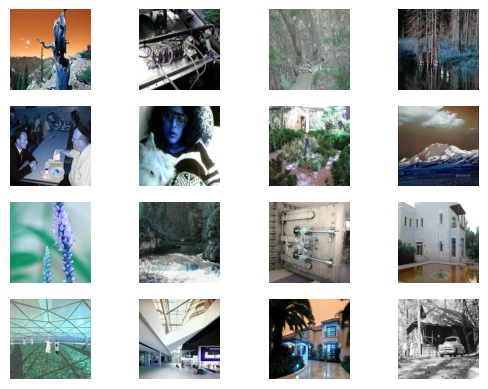

In [ ]:
z = next(iter(train_dataloader))

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow(z[2][i].detach().numpy())

In [ ]:
# for i in range (16):
#   plt.subplot(4,4,i+1)
#   plt.axis("off")
#   plt.imshow(z[0][i].detach().numpy())

In [ ]:
# for i in range (16):
1#   plt.subplot(4,4,i+1)
#   plt.axis("off")
#   plt.imshow(z[1][i].detach().numpy())

#MODEL

In [ ]:
!git clone https://github.com/gabrielBarbutti/lama.git

Cloning into 'lama'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 69 (delta 36), reused 39 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 27.17 KiB | 13.59 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [ ]:
!gdown 1viaxl1sYNSp6wQLDRk2Z1NqFYdKgQWqz # lama pretrained weights

Downloading...
From (original): https://drive.google.com/uc?id=1viaxl1sYNSp6wQLDRk2Z1NqFYdKgQWqz
From (redirected): https://drive.google.com/uc?id=1viaxl1sYNSp6wQLDRk2Z1NqFYdKgQWqz&confirm=t&uuid=c6fd66df-3ed2-4c90-9f92-76705bb6905f
To: /content/model_epochs_17_batch_3000_03-01-2022_08h22.pth
100% 74.0M/74.0M [00:01<00:00, 73.9MB/s]


In [ ]:
"""
1. comment out line 78 and 3
2. install lpips, tqdm
3. create a folder named masks
3. At line 67 add `save_image(mask[j], 'masks/'+dataset.paths[(4*i)+j])`
"""

In [ ]:
# do add code to SAVE THE MASKS ALSO
!python lama/eval.py --experiment baseline \
                --data_path train_images \
                --checkpoint_path /content/model_epochs_17_batch_3000_03-01-2022_08h22.pth #Path/of/your/weight

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:01<00:00, 178MB/s]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
/usr/local/lib/python3.10/dist-packages/lp

In [ ]:
!zip -r masks.zip masks

  adding: masks/ (stored 0%)
  adding: masks/coffee_shop74_.jpg (deflated 54%)
  adding: masks/asia492_.jpg (deflated 64%)
  adding: masks/science_museum1472_.jpg (deflated 51%)
  adding: masks/ski_slope223_.jpg (deflated 48%)
  adding: masks/ski_resort1311_.jpg (deflated 58%)
  adding: masks/landing_deck1209_.jpg (deflated 51%)
  adding: masks/computer_room411_.jpg (deflated 39%)
  adding: masks/bar434_.jpg (deflated 60%)
  adding: masks/ruin500_.jpg (deflated 38%)
  adding: masks/cafeteria1437_.jpg (deflated 47%)
  adding: masks/engine_room783_.jpg (deflated 57%)
  adding: masks/car_interior368_.jpg (deflated 38%)
  adding: masks/football614_.jpg (deflated 64%)
  adding: masks/beer_garden1047_.jpg (deflated 43%)
  adding: masks/butchers_shop859_.jpg (deflated 61%)
  adding: masks/toyshop62_.jpg (deflated 58%)
  adding: masks/sandbox114_.jpg (deflated 53%)
  adding: masks/hospital_room154_.jpg (deflated 34%)
  adding: masks/windmill928_.jpg (deflated 35%)
  adding: masks/butte15_.jpg 

In [ ]:
!zip -r lama_imgs.zip test_images

  adding: test_images/ (stored 0%)
  adding: test_images/coffee_shop74_.jpg (deflated 1%)
  adding: test_images/asia492_.jpg (deflated 1%)
  adding: test_images/science_museum1472_.jpg (deflated 2%)
  adding: test_images/ski_slope223_.jpg (deflated 1%)
  adding: test_images/ski_resort1311_.jpg (deflated 1%)
  adding: test_images/landing_deck1209_.jpg (deflated 2%)
  adding: test_images/computer_room411_.jpg (deflated 1%)
  adding: test_images/bar434_.jpg (deflated 1%)
  adding: test_images/ruin500_.jpg (deflated 1%)
  adding: test_images/cafeteria1437_.jpg (deflated 1%)
  adding: test_images/engine_room783_.jpg (deflated 1%)
  adding: test_images/car_interior368_.jpg (deflated 1%)
  adding: test_images/football614_.jpg (deflated 2%)
  adding: test_images/beer_garden1047_.jpg (deflated 1%)
  adding: test_images/butchers_shop859_.jpg (deflated 1%)
  adding: test_images/toyshop62_.jpg (deflated 1%)
  adding: test_images/sandbox114_.jpg (deflated 2%)
  adding: test_images/hospital_room154_

In [ ]:
! gdown 15gbGYCGZY__Hchja-wPbqZqGj431-8ih # mat file

Downloading...
From (original): https://drive.google.com/uc?id=15gbGYCGZY__Hchja-wPbqZqGj431-8ih
From (redirected): https://drive.google.com/uc?id=15gbGYCGZY__Hchja-wPbqZqGj431-8ih&confirm=t&uuid=7a8742db-5be2-43cd-839a-dca8de39334e
To: /content/Places_512.pkl
100% 661M/661M [00:11<00:00, 55.5MB/s]


In [ ]:
! git clone https://github.com/fenglinglwb/MAT.git # default resolution is 256

Cloning into 'MAT'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 199 (delta 42), reused 39 (delta 39), pack-reused 148 (from 1)
Receiving objects: 100% (199/199), 18.89 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
"""
1. at line 29 `
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256,256))
])`

2. line 125 `        return transform(image)`

3. at line 146 `
                mask = cv2.imread(mask_list[i], cv2.IMREAD_GRAYSCALE)

                # Resizing and normalizing the mask
                mask = transform(PIL.Image.fromarray(mask))

                mask = np.asarray(mask).astype(np.float32) / 255.0

                mask = torch.from_numpy(mask).float().to(device).unsqueeze(0).unsqueeze(0)`

4. at line 162 `output = cv2.resize(output, (256, 256))`

"""

In [ ]:
!pip install ninja


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.5 MB/s eta 0:00:00


In [ ]:
#  also add code to first resize(512*512) and later downsize(256*256) to  the imgs
!python MAT/generate_image.py --network /content/Places_512.pkl --dpath train_images --outdir out_path_rg --mpath masks

Loading data from: train_images
Loading mask from: masks
Loading networks from: /content/Places_512.pkl
Prcessing: airfield1446_.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Prcessing: airfield1447_.png
Prcessing: airfield1448_.png
Prcessing: airfield1449_.png
Prcessing: airfield1450_.png
Prcessing: airplane_cabin865_.png
Prcessing: airplane_cabin866_.png
Prcessing: airplane_cabin867_.png
Prcessing: airplane_cabin868_.png
Prcessing: airplane_cabin869_.png
Prcessing: airport_terminal1341_.png
Prcessing: airport_terminal1342_.png
Prcessing: airport_terminal1343_.png
Prcessing: airport_terminal1344_.png
Prcessing: airport_terminal1345_.png
Prcessing: alcove435_.png
Prcessing: alcove436_.png
Prcessing: alcove437_.png
Prcessing: alcove438_.png
Prcessing: alcove439_.png
Prcessing: alley335_.png
Prcessing: alley336_.png
Prcessing: alley337_.png
Prcessing: alley338_.png
Prcessing: alley339_.png
Prcessing: amphitheater875_.png
Pr

In [ ]:
!zip -r mat_images.zip out_path_rg

  adding: out_path_rg/ (stored 0%)
  adding: out_path_rg/golf_course1365_.png (deflated 0%)
  adding: out_path_rg/office_cubicles207_.png (deflated 0%)
  adding: out_path_rg/airfield1447_.png (deflated 0%)
  adding: out_path_rg/bridge522_.png (deflated 0%)
  adding: out_path_rg/living_room851_.png (deflated 0%)
  adding: out_path_rg/corn_field1524_.png (deflated 0%)
  adding: out_path_rg/indoor1245_.png (deflated 0%)
  adding: out_path_rg/aqueduct78_.png (deflated 0%)
  adding: out_path_rg/army_base544_.png (deflated 0%)
  adding: out_path_rg/throne_room790_.png (deflated 0%)
  adding: out_path_rg/ski_resort1311_.png (deflated 0%)
  adding: out_path_rg/igloo1478_.png (deflated 0%)
  adding: out_path_rg/artists_loft518_.png (deflated 0%)
  adding: out_path_rg/pantry837_.png (deflated 0%)
  adding: out_path_rg/vineyard472_.png (deflated 0%)
  adding: out_path_rg/storage_room104_.png (deflated 0%)
  adding: out_path_rg/highway1368_.png (deflated 0%)
  adding: out_path_rg/fire_station1412_

In [ ]:
!ls

lama		model_epochs_17_batch_3000_03-01-2022_08h22.pth  test_images
lama_imgs.zip	out_path					 train_images
masks		out_path_final					 train_images_for_lama_mat.zip
masks.zip	out_path_rg					 train_imgs
MAT		Places_512.pkl
mat_images.zip	sample_data


In [ ]:
len(os.listdir('test_images'))

1571

In [ ]:
# download bothe the lama_imgs, masks and mat_imgs

## LAMA DENOISER

In [ ]:
# Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Generate images using pretrained network pickle."""
import cv2
import pyspng
import glob
import os
import re
import random
from typing import List, Optional

import click
import dnnlib
import numpy as np
import PIL.Image
import PIL
import torch
import torch.nn.functional as F

import legacy
from datasets.mask_generator_512 import RandomMask
from networks.mat import Generator
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((512,512))
])
transform2 = transforms.Compose([
    transforms.Resize((256,256))
])

def num_range(s: str) -> List[int]:
    '''Accept either a comma separated list of numbers 'a,b,c' or a range 'a-c' and return as a list of ints.'''

    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]


def copy_params_and_buffers(src_module, dst_module, require_all=False):
    assert isinstance(src_module, torch.nn.Module)
    assert isinstance(dst_module, torch.nn.Module)
    src_tensors = {name: tensor for name, tensor in named_params_and_buffers(src_module)}
    for name, tensor in named_params_and_buffers(dst_module):
        assert (name in src_tensors) or (not require_all)
        if name in src_tensors:
            tensor.copy_(src_tensors[name].detach()).requires_grad_(tensor.requires_grad)


def params_and_buffers(module):
    assert isinstance(module, torch.nn.Module)
    return list(module.parameters()) + list(module.buffers())


def named_params_and_buffers(module):
    assert isinstance(module, torch.nn.Module)
    return list(module.named_parameters()) + list(module.named_buffers())


@click.command()
@click.pass_context
@click.option('--network', 'network_pkl', help='Network pickle filename', required=True)
@click.option('--dpath', help='the path of the input image', required=True)
@click.option('--mpath', help='the path of the mask')
@click.option('--resolution', type=int, help='resolution of input image', default=512, show_default=True)
@click.option('--trunc', 'truncation_psi', type=float, help='Truncation psi', default=1, show_default=True)
@click.option('--noise-mode', help='Noise mode', type=click.Choice(['const', 'random', 'none']), default='const', show_default=True)
@click.option('--outdir', help='Where to save the output images', type=str, required=True, metavar='DIR')
def generate_images(
    ctx: click.Context,
    network_pkl: str,
    dpath: str,
    mpath: Optional[str],
    resolution: int,
    truncation_psi: float,
    noise_mode: str,
    outdir: str,
):
    """
    Generate images using pretrained network pickle.
    """
    seed = 240  # pick up a random number
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    print(f'Loading data from: {dpath}')
    img_list = sorted(glob.glob(dpath + '/*.png') + glob.glob(dpath + '/*.jpg'))

    if mpath is not None:
        print(f'Loading mask from: {mpath}')
        mask_list = sorted(glob.glob(mpath + '/*.png') + glob.glob(mpath + '/*.jpg'))
        assert len(img_list) == len(mask_list), 'illegal mapping'

    print(f'Loading networks from: {network_pkl}')
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G_saved = legacy.load_network_pkl(f)['G_ema'].to(device).eval().requires_grad_(False) # type: ignore
    net_res = 512 if resolution > 512 else resolution
    G = Generator(z_dim=512, c_dim=0, w_dim=512, img_resolution=net_res, img_channels=3).to(device).eval().requires_grad_(False)
    copy_params_and_buffers(G_saved, G, require_all=True)

    os.makedirs(outdir, exist_ok=True)

    # no Labels.
    label = torch.zeros([1, G.c_dim], device=device)

    def read_image(image_path):
        with open(image_path, 'rb') as f:
            if pyspng is not None and image_path.endswith('.png'):
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis] # HW => HWC
            image = np.repeat(image, 3, axis=2)
        image = image.transpose(2, 0, 1) # HWC => CHW
        image = image[:3]
        return image

    def to_image(image, lo, hi):
        image = np.asarray(image, dtype=np.float32)
        image = (image - lo) * (255 / (hi - lo))
        image = np.rint(image).clip(0, 255).astype(np.uint8)
        image = np.transpose(image, (1, 2, 0))
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)
        return image

    if resolution != 512:
        noise_mode = 'random'
    with torch.no_grad():
        for i, ipath in enumerate(img_list):
            iname = os.path.basename(ipath).replace('.jpg', '.png')
            print(f'Prcessing: {iname}')
            x = read_image(ipath)
            x = np.transpose(x, (1, 2, 0))  # Transpose to (256, 256, 3)
            x = PIL.Image.fromarray(x)
            x = transform(x)
            image = np.asarray(x)
            image = np.transpose(image, ( 2, 0, 1))  # Transpose to (256, 256, 3)
            image = np.copy(image)


            image = (torch.from_numpy(image).float().to(device) / 127.5 - 1).unsqueeze(0)

            if mpath is not None:
                mask = cv2.imread(mask_list[i], cv2.IMREAD_GRAYSCALE)

                # Resizing and normalizing the mask
                mask = transform(PIL.Image.fromarray(mask))

                mask = np.asarray(mask).astype(np.float32) / 255.0

                mask = torch.from_numpy(mask).float().to(device).unsqueeze(0).unsqueeze(0)

                # mask = cv2.imread(mask_list[i], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
                # mask = torch.from_numpy(mask).float().to(device).unsqueeze(0).unsqueeze(0)
            else:
                mask = RandomMask(resolution) # adjust the masking ratio by using 'hole_range'
                mask = torch.from_numpy(mask).float().to(device).unsqueeze(0)

            # print(f"IMAGE shape : {image.shape}")
            # print(f"MASK shape : {mask.shape}")
            z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
            output = G(image, mask, z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
            output = (output.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
            output = output[0].cpu().numpy()
            output = cv2.resize(output, (256, 256))
            PIL.Image.fromarray(output, 'RGB').save(f'{outdir}/{iname}')


if __name__ == "__main__":
    generate_images() # pylint: disable=no-value-for-parameter

#----------------------------------------------------------------------------


#LOSS

#TRAIN

# other